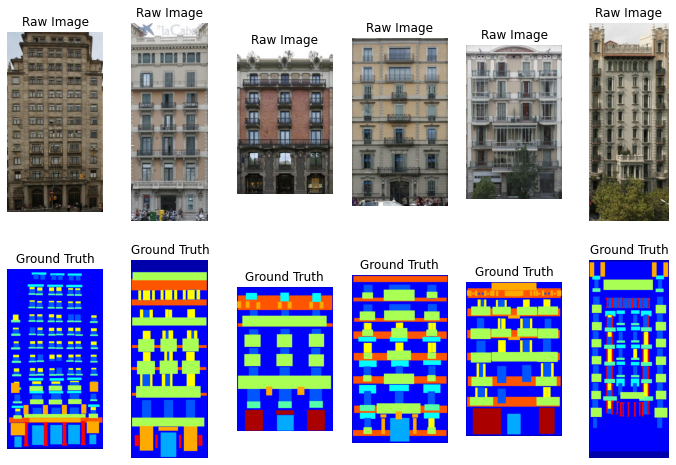

In [4]:
import matplotlib.pyplot as plt
import numpy as np
# import PI

idxs = [1, 2, 5, 6, 7, 8]
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(12, 8))
for i, idx in enumerate(idxs):
    pic = plt.imread("dataset/base/cmp_b000{}.jpg".format(idx))
    label = plt.imread("dataset/base/cmp_b000{}.png".format(idx), format="PNG")

    axes[0][i].axis('off')
    axes[0][i].imshow(pic)
    axes[0][i].set_title("Raw Image")

    axes[1][i].imshow(label)
    axes[1][i].axis('off')
    axes[1][i].set_title("Ground Truth")


In [5]:
import numpy as np

def _hist(pred, gt, n_class):
#     mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * gt.astype(int) +
        pred, minlength=n_class ** 2
    ).reshape(n_class, n_class)
    return hist


def metrics(preds, gts, n_class):
    hist = np.zeros((n_class, n_class))
    for pred, gt in zip(preds, gts):
        hist += _hist(pred.flatten(), gt.flatten(), n_class)
    acc = np.diag(hist).sum() / hist.sum()
    iou = np.diag(hist) / (
        hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist)
    )
    mean_iou = np.nanmean(iou)
    return acc, mean_iou

In [6]:
import torch
import PIL
from torch.utils.data import Dataset
import os
import os.path as osp
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.transforms as T
from PIL import Image
import numpy as np
import cv2


def get_full_list(
    root_dir,
    base_dir="base",
    extended_dir="extended",
):
    data_list = []
    for name in [base_dir, extended_dir]:
        data_dir = osp.join(
            root_dir, name
        )
        data_list += sorted(
            osp.join(data_dir, img_name) for img_name in
            filter(
                lambda x: x[-4:] == '.jpg',
                os.listdir(data_dir)
            )
        )
    return data_list

class CMP_Facade_DB(Dataset):
    def __init__(
        self,
        data_list
    ):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)
                
    def __getitem__(self, i):
        # input and target images
        in_name = self.data_list[i]
        gt_name = self.data_list[i].replace('.jpg','.png')
    
        # process the images
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
        transf_img = transforms.Compose([
            transforms.ToTensor(),
            normalize
        ])
        
        in_image = Image.open(in_name).convert('RGB')
        gt_label = Image.open(gt_name)
        w, h = in_image.size
        gt_label = np.frombuffer(gt_label.tobytes(), dtype=np.ubyte).reshape((h, w))
        
        in_image = cv2.resize(np.array(in_image), None, fx=0.5, fy=0.5, interpolation = cv2.INTER_NEAREST)
        gt_label = cv2.resize(np.array(gt_label), None, fx=0.5, fy=0.5, interpolation = cv2.INTER_NEAREST)
        
        in_image = transf_img(in_image)
        gt_label = torch.tensor(gt_label)
        gt_label = (gt_label).long() - 1

        return in_image, gt_label
    
    def revert_input(self, img, label):
        img = np.transpose(img.cpu().numpy(), (1, 2, 0))
        std_img = np.array([0.229, 0.224, 0.225]).reshape((1, 1, -1))
        mean_img = np.array([0.485, 0.456, 0.406]).reshape((1, 1, -1))
        img *= std_img
        img += mean_img
        label = label.cpu().numpy()
        return img, label + 1


TRAIN_SIZE = 500
VAL_SIZE = 30
TEST_SIZE = 70
full_data_list = get_full_list("dataset")

train_data_set = CMP_Facade_DB(full_data_list[: TRAIN_SIZE])
val_data_set = CMP_Facade_DB(full_data_list[TRAIN_SIZE: TRAIN_SIZE + VAL_SIZE])
test_data_set = CMP_Facade_DB(full_data_list[TRAIN_SIZE + VAL_SIZE:])

print("Training Set Size:", len(train_data_set))
print("Validation Set Size:", len(val_data_set))
print("Test Set Size:", len(test_data_set))


train_loader = torch.utils.data.DataLoader(
    train_data_set, batch_size=1, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_data_set, batch_size=1, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_data_set, batch_size=1, shuffle=False
)



USE_GPU = True

dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print_every = 100

print('using device:', device)

Training Set Size: 500
Validation Set Size: 30
Test Set Size: 76
using device: cuda


In [1]:
# FCN-32

In [7]:
import torch.nn as nn

def get_upsampling_weight(in_channels, out_channels, kernel_size):
    """Make a 2D bilinear kernel suitable for upsampling"""
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                      dtype=np.float64)
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight).float()

class FCN32s(nn.Module):
    def __init__(self, n_class=12):
        super(FCN32s, self).__init__()
        
        # YOUR CODE HERE
        self.n_class = n_class
        
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size = 3, padding = 100)
        self.relu1_1 = nn.ReLU()
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size = 3, padding = 1, stride =1)
        self.relu1_2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size = (2,2), ceil_mode = True)
        
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
        self.relu2_1 = nn.ReLU()
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size = 3, padding = 1, stride =1)
        self.relu2_2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size = (2,2), ceil_mode = True)
        
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size = 3, padding = 1)
        self.relu3_1 = nn.ReLU()
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size = 3, padding = 1, stride =1)
        self.relu3_2 = nn.ReLU()
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size = 3, padding = 1, stride =1)
        self.relu3_3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size = (2,2), ceil_mode = True)
        
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size = 3, padding = 1)
        self.relu4_1 = nn.ReLU()
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1, stride =1)
        self.relu4_2 = nn.ReLU()
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1, stride =1)
        self.relu4_3 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size = (2,2), ceil_mode = True)
        
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1)
        self.relu5_1 = nn.ReLU()
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1, stride =1)
        self.relu5_2 = nn.ReLU()
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1, stride =1)
        self.relu5_3 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(kernel_size = (2,2), ceil_mode = True)
        
        self.fc6 = nn.Conv2d(512, 4096, kernel_size = 7, stride = 1)
        self.relu_6 = nn.ReLU()
        self.dropout_6 = nn.Dropout2d()
        
        self.fc7 = nn.Conv2d(4096, 4096, kernel_size = 1)
        self.relu_7 = nn.ReLU()
        self.dropout_7 = nn.Dropout2d()
        self.score = nn.Conv2d(4096, self.n_class, 1)
        
        self.transpose_conv = nn.ConvTranspose2d(n_class, n_class, kernel_size = 64, stride = 32, bias = False)
        
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 m.weight.data.zero_()
#                 if m.bias is not None:
#                     m.bias.data.zero_()
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)

    def forward(self, x):

        inp = np.array(x.shape)
        x = self.conv1_1(x)
        x = self.relu1_1(x)
        x = self.conv1_2(x)
        x = self.relu1_2(x)
        x = self.pool1(x)
        
        x = self.conv2_1(x)
        x = self.relu2_1(x)
        x = self.conv2_2(x)
        x = self.relu2_2(x)
        x = self.pool2(x)
        
        x = self.conv3_1(x)
        x = self.relu3_1(x)
        x = self.conv3_2(x)
        x = self.relu3_2(x)
        x = self.conv3_3(x)
        x = self.relu3_3(x)
        x = self.pool3(x)
        
        x = self.conv4_1(x)
        x = self.relu4_1(x)
        x = self.conv4_2(x)
        x = self.relu4_2(x)
        x = self.conv4_3(x)
        x = self.relu4_3(x)
        x = self.pool4(x)
        
        x = self.conv5_1(x)
        x = self.relu5_1(x)
        x = self.conv5_2(x)
        x = self.relu5_2(x)
        x = self.conv5_3(x)
        x = self.relu5_3(x)
        x = self.pool5(x)
        
        x = self.fc6(x)
        x = self.relu_6(x)
        x = self.dropout_6(x)
        
        x = self.fc7(x)
        x = self.relu_7(x)
        x = self.dropout_7(x)
        
        x = self.score(x)
        
        h = self.transpose_conv(x)
        
        return h[:,:, 19: 19+inp[2], 19:19+inp[3]]

    
    def copy_params_from_vgg16(self, vgg16):
        features = [
            self.conv1_1, self.relu1_1,
            self.conv1_2, self.relu1_2,
            self.pool1,
            self.conv2_1, self.relu2_1,
            self.conv2_2, self.relu2_2,
            self.pool2,
            self.conv3_1, self.relu3_1,
            self.conv3_2, self.relu3_2,
            self.conv3_3, self.relu3_3,
            self.pool3,
            self.conv4_1, self.relu4_1,
            self.conv4_2, self.relu4_2,
            self.conv4_3, self.relu4_3,
            self.pool4,
            self.conv5_1, self.relu5_1,
            self.conv5_2, self.relu5_2,
            self.conv5_3, self.relu5_3,
            self.pool5,
        ]
        for l1, l2 in zip(vgg16.features, features):
            if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                assert l1.weight.size() == l2.weight.size()
                assert l1.bias.size() == l2.bias.size()
                l2.weight.data = l1.weight.data
                l2.bias.data = l1.bias.data
        for i, name in zip([0, 3], ['fc6', 'fc7']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data = l1.weight.data.view(l2.weight.size())
            l2.bias.data = l1.bias.data.view(l2.bias.size())


## 1.2  Train FCN-32s from scratch

In [8]:
import copy

def Evaluate(
    val_loader,
    model,
    current_best,
    n_class=12
):
    val_loss = 0
    visualizations = []
    preds, gts = [], []
    
    model.eval()
    for batch_idx, (data, target) in enumerate(val_loader):
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            score = model(data)

        pred = score.max(1)[1].cpu().numpy()
        gt = target.cpu().numpy()
        preds.append(pred)
        gts.append(gt)

    avg_acc, mean_iou = metrics(
        preds, gts, n_class)

    if mean_iou > current_best["IoU"]:
        current_best["IoU"] = mean_iou
        current_best["model"] = copy.deepcopy(model)

    return avg_acc, mean_iou, current_best

def Train(
    model,
    loss_func,
    optim,
    scheduler,
    epochs,
    train_loader,
    val_loader,
    test_loader,
    display_interval = 100
):

    current_best = {
        "IoU": 0,
        "model": model
    }
    avg_acc, mean_iou, current_best = Evaluate(
        val_loader,
        model,
        current_best
    )
    
    print("Init Model")
    print("Avg Acc: {:.4}, Mean IoU: {:.4}".format(
        avg_acc, mean_iou
    ))
    for i in range(epochs):
        print("Epochs: {}".format(i))
        total_loss = 0
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to("cuda:0"), target.to("cuda:0")
            optim.zero_grad()

            score = model(data)
            loss = loss_func(score, target.squeeze(1))
            loss_data = loss.item()
            if np.isnan(loss_data):
                raise ValueError('loss is nan while training')
            loss.backward()
            optim.step()
            total_loss += loss.item()
            # if batch_idx % display_interval == 0 and batch_idx != 0:
            #     print("{} / {}, Current Avg Loss:{:.4}".format(
            #         batch_idx, len(train_loader), total_loss / (batch_idx + 1)
            #     ))
            
        
        total_loss /= len(train_loader)
        model.eval()
        avg_acc, mean_iou, current_best = Evaluate(
            val_loader,
            model,
            current_best
        )
        scheduler.step(total_loss)
        print("Avg Loss: {:.4}, Avg Acc: {:.4}, Mean IoU: {:.4}".format(
            total_loss, avg_acc, mean_iou
        ))
    
    test_acc, test_iou, current_best = Evaluate(
        val_loader,
        current_best["model"],
        current_best
    )
    print("Test Acc: {:.4}, Test Mean IoU: {:.4}".format(
        test_acc, test_iou
    ))
    return current_best["model"]


from torch.optim.lr_scheduler import ReduceLROnPlateau

def Trainer(model, 
            train_loader,
            val_loader,
            test_loader,
            num_epochs=25, 
            ):
    # define optimizer
    lr = 1e-4
    weight_decay = 2e-5
    optim = torch.optim.Adam(
        model.parameters(),
        lr=lr,
        weight_decay=weight_decay,
    )
    
    # define learning rate schedule
    scheduler = ReduceLROnPlateau(
        optim, 'min', patience=3,
        min_lr=1e-10, verbose=True
    )
    
    # define loss function
    loss_func = nn.CrossEntropyLoss()

    best_model = Train(
        model,
        loss_func,
        optim,
        scheduler,
        num_epochs,
        train_loader,
        val_loader,
        test_loader
    )

    return best_model

In [9]:
model32 = FCN32s(n_class=12)
model32.to(device)

best_model = Trainer(
    model32,
    train_loader,
    val_loader,
    test_loader,
    num_epochs=10
)

/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Init Model
Avg Acc: 0.3431, Mean IoU: 0.02859
Epochs: 0
Avg Loss: 1.945, Avg Acc: 0.3434, Mean IoU: 0.02871
Epochs: 1
Avg Loss: 1.888, Avg Acc: 0.3897, Mean IoU: 0.05232
Epochs: 2
Avg Loss: 1.766, Avg Acc: 0.4346, Mean IoU: 0.07215
Epochs: 3
Avg Loss: 1.729, Avg Acc: 0.4131, Mean IoU: 0.06019
Epochs: 4
Avg Loss: 1.713, Avg Acc: 0.4433, Mean IoU: 0.07102
Epochs: 6
Avg Loss: 1.696, Avg Acc: 0.4364, Mean IoU: 0.06912
Epochs: 7
Avg Loss: 1.68, Avg Acc: 0.4342, Mean IoU: 0.06866
Epochs: 8
Avg Loss: 1.658, Avg Acc: 0.436, Mean IoU: 0.0789
Epochs: 9
Avg Loss: 1.647, Avg Acc: 0.4426, Mean IoU: 0.07346
Test Acc: 0.436, Test Mean IoU: 0.0789


In [10]:
def visualize(model, test_loader):
    idxs = [1, 2, 5, 6, 7, 8]
    fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(12, 8))
    model.eval()
    for i, idx in enumerate(idxs):
        img, label = test_loader.dataset[idx]
        
        pred = model(img.unsqueeze(0).to(device)) 
        pred = (pred.max(1)[1] + 1).squeeze(0).cpu().numpy()
        
        img, label = test_loader.dataset.revert_input(img, label)
        
        axes[0][i].axis('off')
        axes[0][i].imshow(img)
        axes[0][i].set_title("Raw Image")

        axes[1][i].imshow(label)
        axes[1][i].axis('off')
        axes[1][i].set_title("Ground Truth")

        axes[2][i].imshow(pred)
        axes[2][i].axis('off')
        axes[2][i].set_title("prediction")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


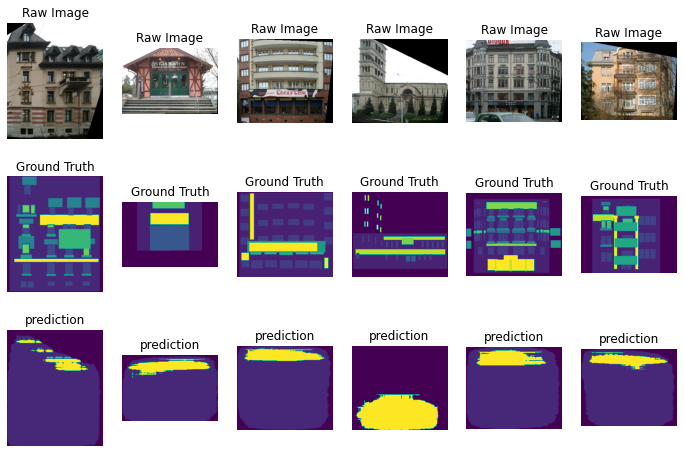

In [11]:
visualize(best_model, test_loader)

In [2]:
# Train FCN-32s with the pretrained VGG16 weights

In [12]:
import torchvision
vgg16 = torchvision.models.vgg16(pretrained=True)

model32_pretrain = FCN32s(n_class=12)
model32_pretrain.copy_params_from_vgg16(vgg16)
model32_pretrain.to(device)

best_model_pretrain = Trainer(
    model32_pretrain,
    train_loader,
    val_loader,
    test_loader,
    num_epochs=20
)

Init Model
Avg Acc: 0.09002, Mean IoU: 0.03398
Epochs: 0
Avg Loss: 1.695, Avg Acc: 0.4784, Mean IoU: 0.1096
Epochs: 1
Avg Loss: 1.451, Avg Acc: 0.5105, Mean IoU: 0.1505
Epochs: 2
Avg Loss: 1.326, Avg Acc: 0.5439, Mean IoU: 0.1824
Epochs: 3
Avg Loss: 1.236, Avg Acc: 0.5652, Mean IoU: 0.2192
Epochs: 4
Avg Loss: 1.157, Avg Acc: 0.5798, Mean IoU: 0.2358
Epochs: 5
Avg Loss: 1.064, Avg Acc: 0.5788, Mean IoU: 0.2033
Epochs: 6
Avg Loss: 0.9882, Avg Acc: 0.6107, Mean IoU: 0.2713
Epochs: 7
Avg Loss: 0.9431, Avg Acc: 0.6109, Mean IoU: 0.2693
Epochs: 8
Avg Loss: 0.8125, Avg Acc: 0.6374, Mean IoU: 0.2985
Epochs: 10
Avg Loss: 0.7747, Avg Acc: 0.6187, Mean IoU: 0.2944
Epochs: 11
Avg Loss: 0.7247, Avg Acc: 0.6397, Mean IoU: 0.3148
Epochs: 12
Avg Loss: 0.6916, Avg Acc: 0.642, Mean IoU: 0.3199
Epochs: 13
Avg Loss: 0.6562, Avg Acc: 0.6335, Mean IoU: 0.3404
Epochs: 14
Avg Loss: 0.6427, Avg Acc: 0.6431, Mean IoU: 0.3343
Epochs: 15
Avg Loss: 0.6086, Avg Acc: 0.6508, Mean IoU: 0.3397
Epochs: 16
Avg Loss: 0.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


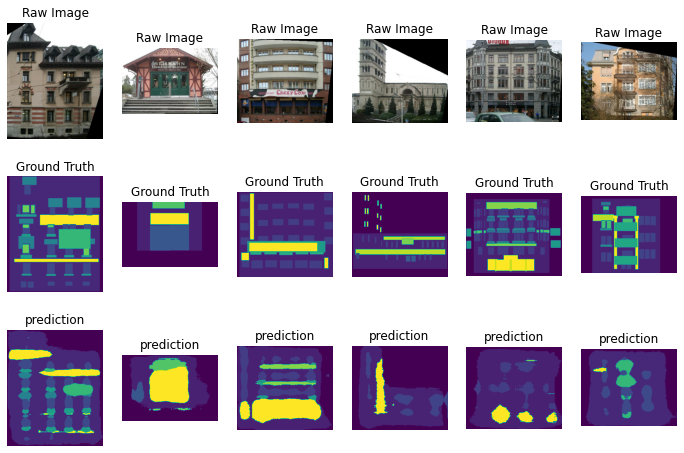

In [13]:
visualize(best_model_pretrain, test_loader)

In [3]:
# Adding skip connectionsd and implementing FCN-8

In [18]:
import torch.nn as nn

class FCN8s(nn.Module):

    def __init__(self, n_class=12):
        super(FCN8s, self).__init__()

        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=100, stride=1)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1, stride =1)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, ceil_mode=True) 

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=1)
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, ceil_mode=True)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=1)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=1)
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, ceil_mode=True)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1, stride=1)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1)
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(kernel_size=2, ceil_mode=True)
        
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1)
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(kernel_size=2, ceil_mode=True)

        self.fc6 = nn.Conv2d(512, 4096, kernel_size=7, padding=0, stride=1)
        self.relu_6 = nn.ReLU(inplace=True)
        self.dropout_6 = nn.Dropout2d()
        
        self.fc7 = nn.Conv2d(4096, 4096, kernel_size=1, padding=0, stride=1)
        self.relu_7 = nn.ReLU(inplace=True)
        self.dropout_7 = nn.Dropout2d()
        
        self.score = nn.Conv2d(4096, n_class, kernel_size=1, stride=1, padding=0)
        
        self.score_pool_3 = nn.Conv2d(256, n_class, kernel_size=1, stride=1, padding=0)
        
        self.score_pool_4 = nn.Conv2d(512, n_class, kernel_size=1, stride=1, padding=0)
        
        self.upscore1 = nn.ConvTranspose2d(n_class, n_class, kernel_size=4, stride=2, bias=False)
        
        self.upscore2 = nn.ConvTranspose2d(n_class, n_class, kernel_size=4, stride=2, bias=False)
        
        self.upscore3 = nn.ConvTranspose2d(n_class, n_class, kernel_size=16, stride=8, bias=False)
        
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            # if isinstance(m, nn.Conv2d):
            #     m.weight.data.zero_()
            #     if m.bias is not None:
            #         m.bias.data.zero_()
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)

                
    def forward(self, x):
        
        out = self.relu1_1(self.conv1_1(x))
        out = self.relu1_2(self.conv1_2(out))
        out = self.pool1(out)
        
        out = self.relu2_1(self.conv2_1(out))
        out = self.relu2_2(self.conv2_2(out))
        out = self.pool2(out)
        
        out = self.relu3_1(self.conv3_1(out))
        out = self.relu3_2(self.conv3_2(out))
        out = self.relu3_3(self.conv3_3(out))
        out3 = self.pool3(out)
        
        out = self.relu4_1(self.conv4_1(out3))
        out = self.relu4_2(self.conv4_2(out))
        out = self.relu4_3(self.conv4_3(out))
        out4 = self.pool4(out)
        
        out = self.relu5_1(self.conv5_1(out4))
        out = self.relu5_2(self.conv5_2(out))
        out = self.relu5_3(self.conv5_3(out))
        out = self.pool5(out)
        
        out = self.fc6(out)
        out = self.relu_6(out)
        out = self.dropout_6(out)
        
        out = self.fc7(out)
        out = self.relu_7(out)
        out = self.dropout_7(out)
        
        out = self.score(out)
        
        # skip connections
        upscore1 = self.upscore1(out)
        
        score_pool4 = self.score_pool_4(out4)
        score_pool4 = score_pool4[:,:,5:5+upscore1.shape[2],5:5+upscore1.shape[3]]
        
        upscore2 = self.upscore2(score_pool4 + upscore1)
        
        score_pool3 = self.score_pool_3(out3)
        score_pool3 = score_pool3[:,:,9:9+upscore2.shape[2],9:9+upscore2.shape[3]]
        
        upscore3 = self.upscore3(score_pool3 + upscore2)
        h = upscore3[:,:,31: 31 + x.shape[2], 31: 31 + x.shape[3]]
        
        return h

    def copy_params_from_vgg16(self, vgg16):
        features = [
            self.conv1_1, self.relu1_1,
            self.conv1_2, self.relu1_2,
            self.pool1,
            self.conv2_1, self.relu2_1,
            self.conv2_2, self.relu2_2,
            self.pool2,
            self.conv3_1, self.relu3_1,
            self.conv3_2, self.relu3_2,
            self.conv3_3, self.relu3_3,
            self.pool3,
            self.conv4_1, self.relu4_1,
            self.conv4_2, self.relu4_2,
            self.conv4_3, self.relu4_3,
            self.pool4,
            self.conv5_1, self.relu5_1,
            self.conv5_2, self.relu5_2,
            self.conv5_3, self.relu5_3,
            self.pool5,
        ]
        for l1, l2 in zip(vgg16.features, features):
            if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                assert l1.weight.size() == l2.weight.size()
                assert l1.bias.size() == l2.bias.size()
                l2.weight.data.copy_(l1.weight.data)
                l2.bias.data.copy_(l1.bias.data)
        for i, name in zip([0, 3], ['fc6', 'fc7']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data.copy_(l1.weight.data.view(l2.weight.size()))
            l2.bias.data.copy_(l1.bias.data.view(l2.bias.size()))


In [19]:
import torchvision
vgg16 = torchvision.models.vgg16(pretrained=True)

model8 = FCN8s(n_class=12)
model8.copy_params_from_vgg16(vgg16)
model8.to(device)

best_model_fcn8s = Trainer(
    model8,
    train_loader,
    val_loader,
    test_loader, 
    num_epochs=20
)

Init Model
Avg Acc: 0.05016, Mean IoU: 0.01972
Epochs: 0
Avg Loss: 1.273, Avg Acc: 0.6171, Mean IoU: 0.32
Epochs: 1
Avg Loss: 0.971, Avg Acc: 0.6487, Mean IoU: 0.3565
Epochs: 2
Avg Loss: 0.8945, Avg Acc: 0.6379, Mean IoU: 0.3364
Epochs: 3
Avg Loss: 0.8066, Avg Acc: 0.6712, Mean IoU: 0.3747
Epochs: 4
Avg Loss: 0.7333, Avg Acc: 0.6933, Mean IoU: 0.4193
Epochs: 5
Avg Loss: 0.6709, Avg Acc: 0.683, Mean IoU: 0.4084
Epochs: 6
Avg Loss: 0.6296, Avg Acc: 0.6913, Mean IoU: 0.4103
Epochs: 7
Avg Loss: 0.5817, Avg Acc: 0.7163, Mean IoU: 0.4415
Epochs: 8
Avg Loss: 0.5198, Avg Acc: 0.7101, Mean IoU: 0.4272
Epochs: 9
Avg Loss: 0.4735, Avg Acc: 0.7099, Mean IoU: 0.421
Epochs: 10
Avg Loss: 0.4348, Avg Acc: 0.7105, Mean IoU: 0.4361
Epochs: 11
Avg Loss: 0.4103, Avg Acc: 0.7176, Mean IoU: 0.4236
Epochs: 12
Avg Loss: 0.3762, Avg Acc: 0.7047, Mean IoU: 0.4422
Epochs: 13
Avg Loss: 0.4034, Avg Acc: 0.7151, Mean IoU: 0.4359
Epochs: 14
Avg Loss: 0.3401, Avg Acc: 0.7253, Mean IoU: 0.4395
Epochs: 15
Avg Loss: 0.3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


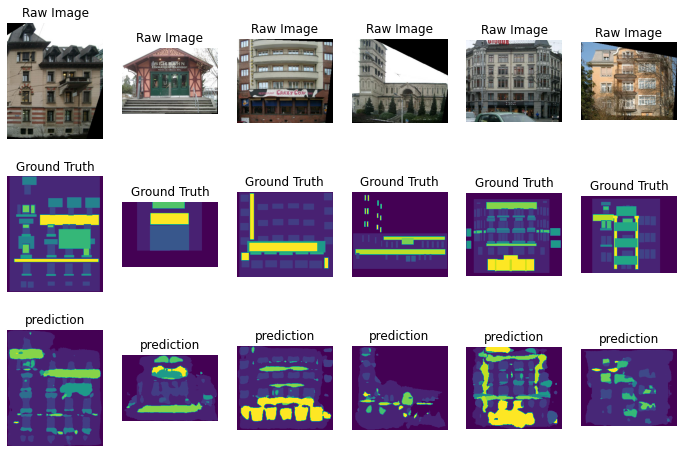

In [20]:
visualize(best_model_fcn8s, test_loader)